# About
[Purpose for this notebook]

Bi-LSTMs are a type of RNNs, and as such, have memory which can store temporal information available in time series data. 

# Bidirectional LSTM

# Libraries

In [1]:
%run "/home/cesar/Python_NBs/HDL_Project/HDL_Project/global_fv.ipynb"

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from keras.models import Sequential

# Layers
from keras.layers import LSTM, Dense, Bidirectional

# Optimizer
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

# Early stopping
from tensorflow.keras.callbacks import EarlyStopping

# Checkpoint
from keras.callbacks import ModelCheckpoint

# Global Parameters

In [3]:
manual_tuning = False

# User-Defined Functions

In [4]:
def design_model(n_steps, n_features, lr):
    """
    n_steps: Number of steps
    n_features: Number of features
    lr: Learning rate
    """
    model = Sequential(name = "Bidirectional-LSTM-model")
    
    # Number of neurons (nodes) are just about greater than the number of features.
    # Rule of thumb is for number of neurons to be about 2/3 of the input    
    num_neurons = int(np.ceil(n_features *2 /3))
    
    # It'd be best for the number of neurons to be in the scale of 2^n for computational purposes.
    if(False):
        while num_neurons > 2**i:
            i += 1

        num_neurons = 2**i   
    
    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(num_neurons, activation= 'relu' ), input_shape=(n_steps, n_features)))
    
    # Output layer with one neuron to a model instance (to return one output)
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    # Regularization prevents the learning process to completely fit the model to the training data which can lead to overfitting.
    # The most common regularization method is dropout.
    #model.add(layers.Dropout(0.1))    
    
    # Optimizer
    opt = Adam(learning_rate=lr)
    model.compile(optimizer=opt,  metrics=['mae'], loss= 'mse')
    
    return model

In [5]:
def manual_tuning_lr(X, y, learning_rate, num_epochs, bs, model):
    y_axis_name = "Learning rate"
    
    #train the model on the training data
    history = model.fit(X, y, epochs=num_epochs, batch_size=bs, verbose = 0, validation_split = 0.2)

    # plot learning curves
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title("Learning Rate: {}".format(str(learning_rate)) )
    plt.ylabel('Loss')
    plt.legend(loc="upper right")    
    return history

In [6]:
def manual_tuning_batches(X, y, learning_rate, num_epochs, bs, model):
    
    #train the model on the training data
    history = model.fit(X, y, epochs=num_epochs, batch_size = bs, verbose=0, validation_split = 0.2)
    
    # plot learning curves
    plt.plot(history.history['mae'], label='train')
    plt.plot(history.history['val_mae'], label='validation')
    plt.title('Batches = ' + str(bs))
    plt.ylabel('mae')
    plt.legend(loc="upper right")
    return history

In [7]:
def fit_model_es_checkpoint(X, y, learning_rate, num_epochs, bs, model):
    checkpoint_name = 'Trained_Models/U_Weights_-{epoch:03d}--{val_loss:.5f}.hdf5'
    
    early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=15)
    checkpoint_callback = ModelCheckpoint(checkpoint_name, monitor='mae', verbose=0, save_best_only=True, mode='min')
    history = NN_model.fit(X, y, epochs=num_epochs, batch_size=bs, validation_split = 0.20, verbose = 0, callbacks=[early_stopping_callback, checkpoint_callback])
    return history

# Data

## Parameters

In [8]:
station_number = 'SE'
target_name = 'pm25'
# Number of time steps per sample
n_steps = 24

# Meteorological parameters
col_names = [i[0] for i in qdata("select meteorological_code from cat_meteorological_params")]

# Default neccesary columns
cols = "datetime, " + target_name

# Columns
for i in col_names:
    cols = cols + ", " + str(i)

print(cols)
    
# Where filter:
where_txt = "where datetime >= \'2021-01-01\'"

datetime, pm25, tout, wdr, wsr, rh, sr, rainf, prs


## Creating samples

In [9]:
# Initializing class
main_processed_df = multivariate_samples(station_number, cols, where_txt)

# Execution of processing functions
#initial_df = main_processed_df.initial_df()

# Samples numpy.ndarray object 
X, y = main_processed_df.samples_creation(n_steps, target_name)
X = np.asarray(X)
y = np.asarray(y)

n_features = np.shape(X)[2]

In [10]:
# Understanding the three-dimensional structure of the input samples
print(np.shape(X))
print()
print("* The 1st dimension is the number of samples, in this case: {}".format(np.shape(X)[0])) 
print("* The 2nd dimension is the number of time steps per sample, in this case {}, the value specified to the function.".format(np.shape(X)[1]))
print("* The 3rd dimension specifies the number of parallel time series —or the number of variables— in this case {}.".format(np.shape(X)[2]))


(11305, 24, 7)

* The 1st dimension is the number of samples, in this case: 11305
* The 2nd dimension is the number of time steps per sample, in this case 24, the value specified to the function.
* The 3rd dimension specifies the number of parallel time series —or the number of variables— in this case 7.


# Data model: Bi-LSTM

In [11]:
learning_rate = 0.01

NN_model = design_model(n_steps, n_features, learning_rate)
NN_model.summary()

Model: "Bidirectional-LSTM-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 10)               520       
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________


In [12]:
#fixed number of epochs
num_epochs = 20

#fixed number of batches
batch_size = 8

if manual_tuning == True:
    # List of learning rates for  testing
    learning_rates = [1, 1E-1, 1E-2, 1E-3, 1E-4, 1E-5]

    plt.figure(figsize=(14,12))
    plt.ylim([150, 200])
    plt.subplots_adjust(bottom=0.1, top=1.4)
    plt.tight_layout()

    for i in range(len(learning_rates)): 
        plt.subplot(len(learning_rates), 1, (i+1))
        manual_tuning_lr(X, y, learning_rates[i], num_epochs, batch_size, design_model(n_steps, n_features, learning_rate))

    plt.show()

    plt.cla()
    plt.clf()
    plt.close('all')

In [13]:
#fixed number of epochs
num_epochs = 20

#fixed learning rate value
learning_rate = 0.01


if manual_tuning == True:
    #fixed number of batches
    batch_size = [8, 16, 32, 64, 128] 
    
    plt.figure(figsize=(14,12))
    plt.subplots_adjust(bottom=0.1, top=1.4)
    
    for i in range(len(batch_size)): 
        plt.subplot(len(batch_size), 1, (i+1))
        manual_tuning_batches(X, y, learning_rate, num_epochs, batch_size[i], design_model(n_steps, n_features, learning_rate))

    #plt.tight_layout()
    plt.show()

    plt.cla()
    plt.clf()
    plt.close('all')

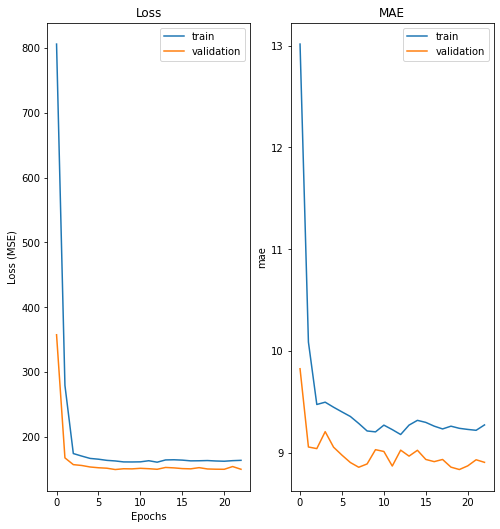

Min training Loss: 160.99978637695312
Min validation Loss:  149.68882751464844

Final training MAE: 9.273297309875488
Final validation MAE: 8.905539512634277


In [14]:
#Training with early stopping

# Maximum number of epochs
num_epochs = 300

#fixed learning rate value
learning_rate = 0.01

#fixed number of batches
batch_size = 4

history = fit_model_es_checkpoint(X, y, learning_rate, num_epochs, batch_size, design_model(n_steps, n_features, learning_rate))
          
#plotting
plt.figure(figsize=(8,5))
plt.subplots_adjust(bottom=0.1, top=1.4)
plt.tight_layout()

# plot learning curves
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title("Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend(loc="upper right")


# plot learning curves
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='validation')
plt.title("MAE")
plt.ylabel('mae')
plt.legend(loc="upper right")

plt.show()

plt.cla()
plt.clf()
plt.close('all')

print("Min training Loss:", min(history.history["loss"]))
print("Min validation Loss: ", min(history.history["val_loss"]))
print("")
print("Final training MAE:", history.history['mae'][-1])
print("Final validation MAE:", history.history['val_mae'][-1])

# Validation

In [15]:
# demonstrate prediction
x_input = np.array([[80, 85], [90, 95], [100, 105]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

ValueError: cannot reshape array of size 6 into shape (1,24,7)

# Test Example

## Libraries

In [ ]:
# multivariate lstm example
from numpy import array
from numpy import hstack

## UDF

In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

## Data

### Raw Dummy Data

In [ ]:
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
dataset

### Parameters

In [ ]:
# choose a number of time steps
n_steps = 3

### Samples

In [ ]:
# convert into input/output
X, y = split_sequences(dataset, n_steps)
X = np.asarray(X)
y = np.asarray(y)

# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
print(np.shape(X))

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(50, activation= 'relu' ), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer= 'adam' , loss= 'mse')

In [ ]:
model.fit(X, y, epochs=200, verbose=0)

In [ ]:
# demonstrate prediction
x_input = array([[80, 85], [90, 95], [100, 105]])
x_input = x_input.reshape((1, n_steps, 2))
yhat = model.predict(x_input, verbose=0)
print(yhat)